# __Heart Disease and Failures__


## Introduction

There are multiple attributes that can contribute to a heart failure.
In order for us to prevent heart failures from earlier on, it is important to be aware of the symptoms and attributes that have the highest correlation to heart failures. 
In this project, our objective is to answer the question of which sex at which age range heart failures most commonly occur and which conditions have the highest possibility to lead/result with heart failures.
The data base we will be using is a re-processed heart disease data from Cleveland UCI which examines 76 observed attributes that are predicted to cause heart failures. We will be referring to the attributes: max heart rate (thalach), cholesterol levels (chol), resting blood pressure(trestbps) and types of chest pains (cp).



In [244]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(ggplot2)

In [245]:
heart_data <- read_csv("https://raw.githubusercontent.com/ssyl29/group_project/main/heart_cleveland_upload.csv")

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  condition = col_double()
)



In [246]:
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
35,0,3,138,183,0,0,182,0,1.4,0,0,0,0
35,1,3,126,282,0,2,156,1,0.0,0,0,2,1


In [247]:
heart_data <- heart_data %>%
    mutate(sex = as.factor(sex),
           sex = recode(sex, "0" = "female", "1" = "male"),
          cp = as.factor(cp),
           cp = recode(cp, "0" = "typical angina",
                      "1" = "atypical angina",
                      "2" = "non-anginal pain",
                      "3" = "asymptomatic"),
           fbs = as.logical(fbs),
          trestbps = as.numeric(trestbps),
           chol = as.numeric(chol),
          fbs = as.numeric(fbs),
           condition = as.factor(condition),
          condition = recode(condition, "0" = "no disease",
                            "1" = "disease"))
#     select(age, sex, cp, trestbps, chol, fbs, thalach, condition)
heart_data
          

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
69,male,typical angina,160,234,1,2,131,0,0.1,1,1,0,no disease
69,female,typical angina,140,239,0,0,151,0,1.8,0,2,0,no disease
66,female,typical angina,150,226,0,0,114,0,2.6,2,0,0,no disease
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,male,asymptomatic,120,198,0,0,130,1,1.6,1,0,2,disease
35,female,asymptomatic,138,183,0,0,182,0,1.4,0,0,0,no disease
35,male,asymptomatic,126,282,0,2,156,1,0.0,0,0,2,disease


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition,age_group
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
69,male,typical angina,160,234,1,2,131,0,0.1,1,1,0,no disease,old
69,female,typical angina,140,239,0,0,151,0,1.8,0,2,0,no disease,old
66,female,typical angina,150,226,0,0,114,0,2.6,2,0,0,no disease,old
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,male,asymptomatic,120,198,0,0,130,1,1.6,1,0,2,disease,young
35,female,asymptomatic,138,183,0,0,182,0,1.4,0,0,0,no disease,young
35,male,asymptomatic,126,282,0,2,156,1,0.0,0,0,2,disease,young


[1] 91

[1] 121

[1] 85

`summarise()` regrouping output by 'cp' (override with `.groups` argument)



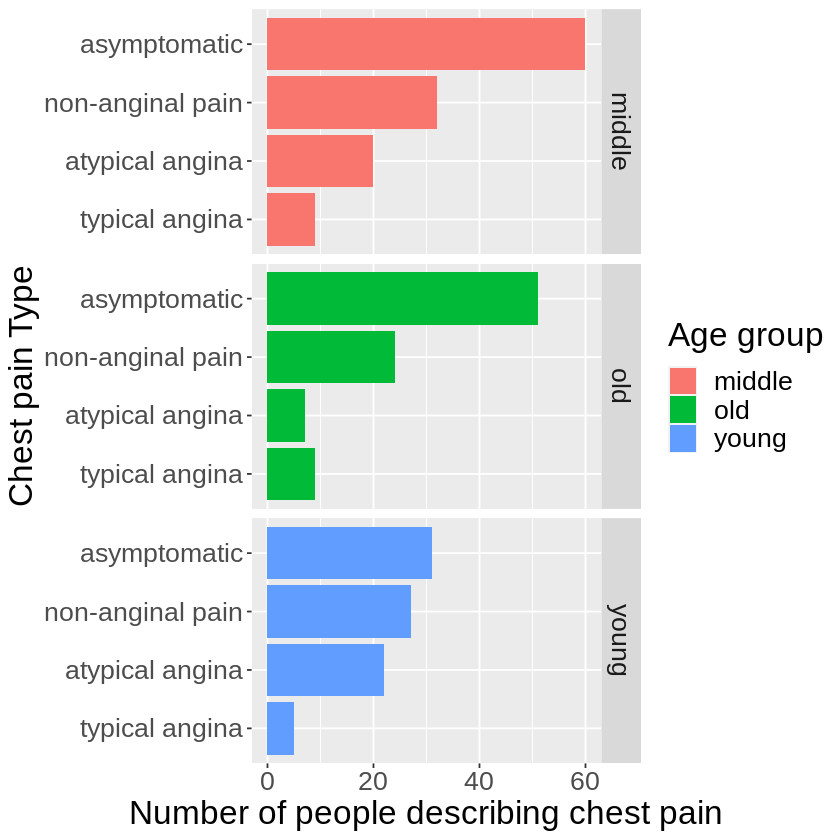

In [248]:
# 1.Divide the dataset into different age group.
heart_data <- within(heart_data,{
  age_group <- NA
  age_group[age>=60]="old"
  age_group[age>= 50 & age < 60] = "middle"
  age_group[age < 50] = "young"
}) 
heart_data

# 2.Count the number in each group
num_old <- heart_data %>%
    filter(age_group == "old") %>%
    nrow()
num_old

num_middle <- heart_data %>%
    filter(age_group == "middle") %>%
    nrow()
num_middle

num_young <- heart_data %>%
    filter(age_group == "young") %>%
    nrow()
num_young

# Note: we can see that the majority of patients with 
# heart failure are between the ages of 50 and 60.

# 3.Find the differnt types of chest pain in each age group
chest_pains_age <- heart_data %>%
    select(cp, age_group) %>%
    group_by(cp, age_group) %>%
    summarize(count = n())

chest_pain_plot <- chest_pains_age %>%
    ggplot(aes(x = count, y = cp, fill = age_group)) +
    geom_bar(stat = "identity", position = "dodge") +
    facet_grid(age_group ~.) +
    labs(x = "Number of people describing chest pain", y = "Chest pain Type",
        fill = "Age group") +
    theme(text = element_text(size = 20))
chest_pain_plot
# 4

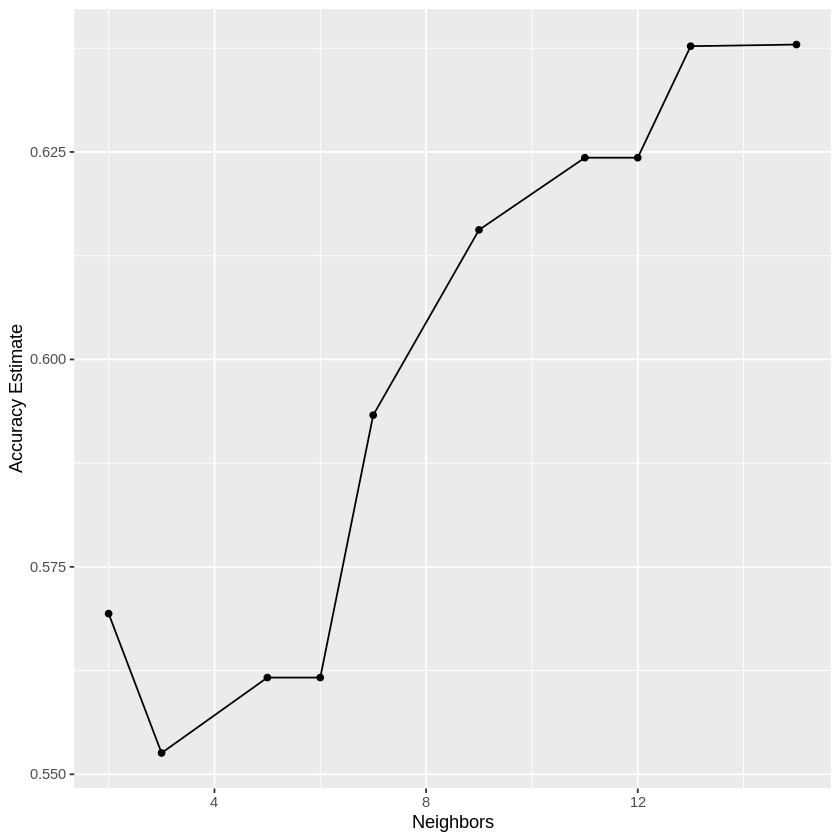

In [249]:
set.seed(2000)
heart_split <- initial_split(heart_data, prop = 0.75, strata = condition)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_vfold <- vfold_cv(heart_train, v = 10, strata = condition)


heart_recipe <- recipe(condition ~ trestbps + chol + fbs + thalach, data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

knn_results <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = heart_vfold, grid = 10) %>%
       collect_metrics()

accuracies <- knn_results %>% 
       filter(.metric == "accuracy")
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_versus_k

In [250]:
set.seed(2000)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>%
       set_engine("kknn") %>%
       set_mode("classification")

heart_fit <- workflow() %>%
       add_recipe(heart_recipe) %>%
       add_model(knn_spec) %>%
       fit(data = heart_train)

heart_test_predictions <- predict(heart_fit , heart_test) %>%
       bind_cols(heart_test)
heart_test_predictions

heart_prediction_accuracy <- heart_test_predictions %>%
         metrics(truth = condition, estimate = .pred_class)  
heart_prediction_accuracy

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition,age_group
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
no disease,69,male,typical angina,160,234,1,2,131,0,0.1,1,1,0,no disease,old
no disease,69,female,typical angina,140,239,0,0,151,0,1.8,0,2,0,no disease,old
disease,66,female,typical angina,150,226,0,0,114,0,2.6,2,0,0,no disease,old
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
no disease,45,male,asymptomatic,115,260,0,2,185,0,0.0,0,0,0,no disease,young
no disease,43,male,asymptomatic,115,303,0,0,181,0,1.2,1,0,0,no disease,young
disease,40,male,asymptomatic,110,167,0,2,114,1,2.0,1,0,2,disease,young


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6621622
kap,binary,0.2997729


In [251]:
# predicting presence of disease

heart_mat <- heart_test_predictions %>%
    conf_mat(truth = condition, estimate = .pred_class)

heart_mat

            Truth
Prediction   no disease disease
  no disease         34      19
  disease             6      15

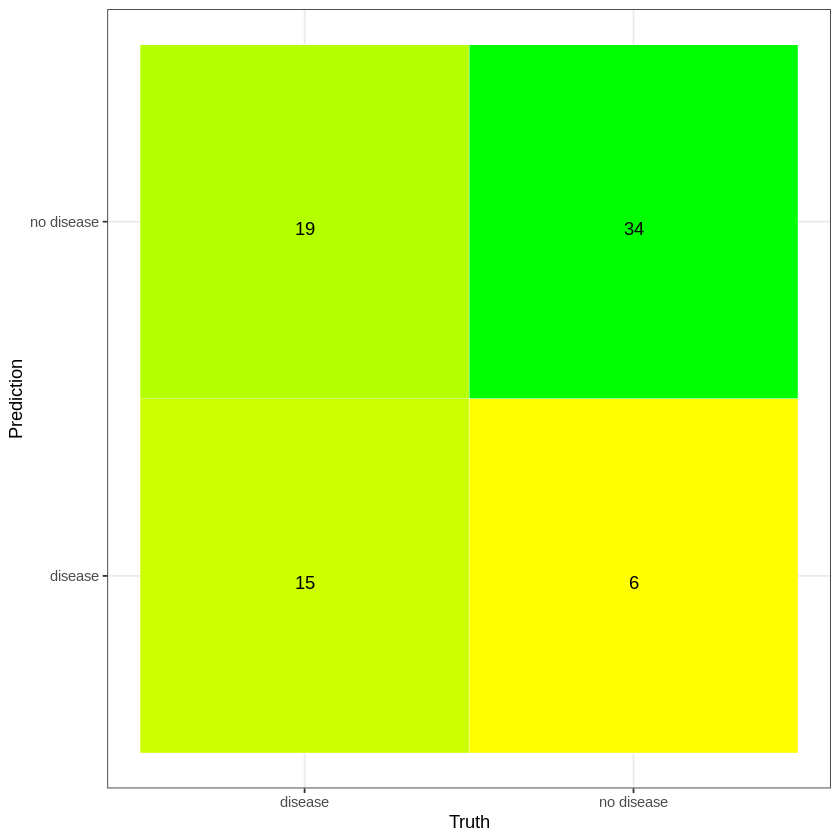

In [252]:
Truth <- factor(c('no disease', 'no disease', 'disease', 'disease'))
Prediction <- factor(c('no disease', 'disease', 'disease', 'no disease'))
Y  <- c(34, 6, 15, 19)
df <- data.frame(Truth, Prediction, Y)

library(ggplot2)

ggplot(data =  df, mapping = aes(x = Truth, y = Prediction)) +
  geom_tile(aes(fill = Y), colour = "white") +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "yellow", high = "green") +
  theme_bw() + theme(legend.position = "none")

In [253]:
set.seed(2000)

cp_recipe <- recipe(cp ~ chol + thalach + trestbps, data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 


knn_cp <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>%
    set_engine("kknn") %>%
    set_mode("classification")

cp_workflow <- workflow() %>%
    add_recipe(cp_recipe) %>%
    add_model(knn_cp)

knn_fit_all <- cp_workflow %>%
    fit(data = heart_train) 


class_prediction_all <- predict(knn_fit_all, heart_test) %>%
                        bind_cols(heart_test)

class_prediction_all


.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition,age_group
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
asymptomatic,69,male,typical angina,160,234,1,2,131,0,0.1,1,1,0,no disease,old
asymptomatic,69,female,typical angina,140,239,0,0,151,0,1.8,0,2,0,no disease,old
asymptomatic,66,female,typical angina,150,226,0,0,114,0,2.6,2,0,0,no disease,old
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
non-anginal pain,45,male,asymptomatic,115,260,0,2,185,0,0.0,0,0,0,no disease,young
non-anginal pain,43,male,asymptomatic,115,303,0,0,181,0,1.2,1,0,0,no disease,young
asymptomatic,40,male,asymptomatic,110,167,0,2,114,1,2.0,1,0,2,disease,young


In [254]:
cp_matrix <- class_prediction_all %>%
    conf_mat(truth = cp, estimate = .pred_class)

cp_matrix

# 21 predicted as asymptopmatic pain
# 6 predicted as non anginal pain
# 3 predicted as atypical pain 
# 0 predicted as typical pain 


                  Truth
Prediction         typical angina atypical angina non-anginal pain asymptomatic
  typical angina                0               0                0            0
  atypical angina               2               3                3            2
  non-anginal pain              3               3                6            7
  asymptomatic                  5               7               12           21

## Discussion
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?



## Citations



*Data Source Citation*


Cherngs. "Heart Disease Cleveland UCI." Kaggle. 29 Mar. 2020. Web. 7 Apr. 2022. &lt;https://www.kaggle.com/cherngs/heart-disease-cleveland-uci&gt;.

"Heart Disease Data Set." UCI Machine Learning Repository: Heart Disease Data Set. David W. Aha. Web. 7 Apr. 2022. &lt;https://archive.ics.uci.edu/ml/datasets/Heart+Disease&gt;.



*Literature Relevant to Project*


Mayo Clinic Staff. “Angina.” Mayo Clinic, Mayo Foundation for Medical Education and Research, 12 June 2020, https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373#:~:text=Unstable%20angina%20worsens%20and%20isn,dangerous%20and%20requires%20emergency%20treatment. 

Mayo Clinic Staff. “Chest Pain.” Mayo Clinic, Mayo Foundation for Medical Education and Research, 20 Oct. 2021, https://www.mayoclinic.org/diseases-conditions/chest-pain/symptoms-causes/syc-20370838. 

“Heart Failure (Congestive Heart Failure): Symptoms &amp; Treatment.” Cleveland Clinic, https://my.clevelandclinic.org/health/diseases/17069-heart-failure-understanding-heart-failure. 